In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/new-york-city-taxi-fare-prediction/sample_submission.csv
/kaggle/input/new-york-city-taxi-fare-prediction/GCP-Coupons-Instructions.rtf
/kaggle/input/new-york-city-taxi-fare-prediction/train.csv
/kaggle/input/new-york-city-taxi-fare-prediction/test.csv


# Case Study 1: New York City Taxi Fare Prediction



The dataset here consists of historical data pertaining to fare amounts (inclusive of tolls) for taxi rides in New York City. There are various attributes here including the fare amount, pickup times, pickup and dropoff co-ordinates and the passenger count! 

The key idea here is if we can build a model on this datset to predict the potential taxi fare for a future taxi ride in NYC given that we know the other attibutes except fare

__Main Objective:__ Given a ride's pickup time, pickup and dropoff coordinates along with the total passengers riding, build a model to predict the fare for a NYC taxi (regression)


In [2]:

#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from warnings import filterwarnings
filterwarnings('ignore')


# Load and View the Dataset

There are over __50 million__ datapoints in this dataset! We load around __10 million__ datapoints for this case study 

The data is available at https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data from where you can download it.

We recommend using the kaggle API and the following command via CLI to get it.

__`kaggle competitions download -c new-york-city-taxi-fare-prediction`__

In [3]:
%%time

df = pd.read_csv('/kaggle/input/new-york-city-taxi-fare-prediction/train.csv', nrows=10000000)
df.shape

CPU times: user 19.5 s, sys: 2.38 s, total: 21.9 s
Wall time: 29.4 s


(10000000, 8)

In [4]:
df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


# EDA

In [5]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,1.000000e+07,1.000000e+07,1.000000e+07,9.999931e+06,9.999931e+06,1.000000e+07
mean,1.133854e+01,-7.250775e+01,3.991934e+01,-7.250897e+01,3.991913e+01,1.684793e+00
std,9.799930e+00,1.299421e+01,9.322539e+00,1.287532e+01,9.237280e+00,1.323423e+00
min,-1.077500e+02,-3.439245e+03,-3.492264e+03,-3.426601e+03,-3.488080e+03,0.000000e+00
25%,6.000000e+00,-7.399207e+01,4.073491e+01,-7.399139e+01,4.073403e+01,1.000000e+00
50%,8.500000e+00,-7.398181e+01,4.075263e+01,-7.398015e+01,4.075316e+01,1.000000e+00
75%,1.250000e+01,-7.396710e+01,4.076712e+01,-7.396367e+01,4.076810e+01,2.000000e+00
max,1.273310e+03,3.457626e+03,3.344459e+03,3.457622e+03,3.351403e+03,2.080000e+02


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   key                object 
 1   fare_amount        float64
 2   pickup_datetime    object 
 3   pickup_longitude   float64
 4   pickup_latitude    float64
 5   dropoff_longitude  float64
 6   dropoff_latitude   float64
 7   passenger_count    int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 610.4+ MB


In [7]:
# key
#it is duplicate of pickup_datetime, we can drop the column

df.drop('key', axis=1, inplace=True)
df.shape

(10000000, 7)

### Fare amount (target)

<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

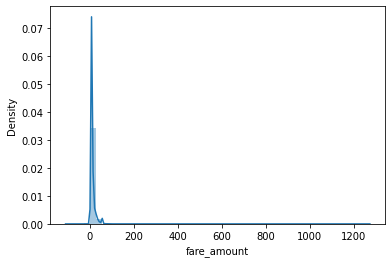

In [8]:
sns.distplot(df['fare_amount'])

<AxesSubplot:xlabel='fare_amount'>

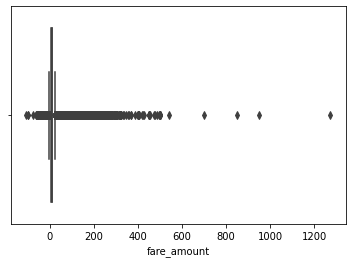

In [9]:
sns.boxplot(df['fare_amount'])

In [10]:
print('Skewness :', df['fare_amount'].skew())
print('Kurtosis :', df['fare_amount'].kurt())

Skewness : 4.4174817480380115
Kurtosis : 85.34291383699755


In [11]:
#The variable is highly right skewed and highly peaked.
#There are ouliers as seen in box plot, we need to treat the outliers

### pickup_datetime

In [12]:
df['pickup_datetime'].dtype

dtype('O')

In [13]:
#the datatype is object instead of datetime, we change the datatype and further analyse

df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 7 columns):
 #   Column             Dtype         
---  ------             -----         
 0   fare_amount        float64       
 1   pickup_datetime    datetime64[ns]
 2   pickup_longitude   float64       
 3   pickup_latitude    float64       
 4   dropoff_longitude  float64       
 5   dropoff_latitude   float64       
 6   passenger_count    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 534.1 MB


In [15]:
df['pickup_datetime'].min(), df['pickup_datetime'].max()
#the dataset contains almost 6.5years of data

(Timestamp('2009-01-01 00:00:46'), Timestamp('2015-06-30 23:59:54'))

### passenger_count

<AxesSubplot:xlabel='passenger_count', ylabel='Density'>

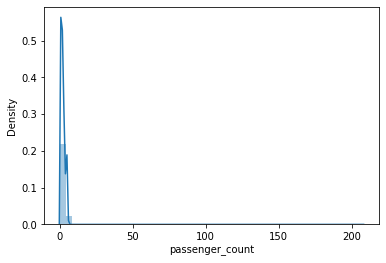

In [16]:
sns.distplot(df['passenger_count'])

#the data is right skewed and it contains outliers

In [17]:
df['passenger_count'].value_counts()

#count of passengers are nearly 129 in one ride, which is highly impossible.
#we can consider the trips where passengers are between 0 to 8 members

1      6917305
2      1476610
5       707721
3       439133
4       212015
6       211867
0        35332
208          9
9            3
7            2
49           1
51           1
129          1
Name: passenger_count, dtype: int64

## Corelation


<AxesSubplot:>

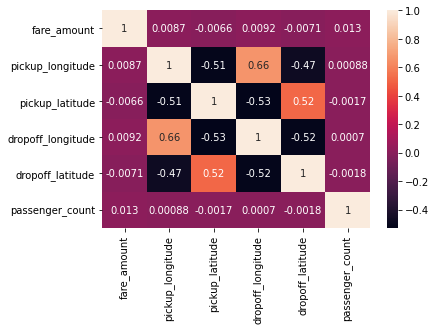

In [18]:
sns.heatmap(df.corr(), annot=True)

#none of the variables are corelated with the target variable

## Data pre-processing

In [19]:
#There are no redundant variables present, we can check for duplicates

df.duplicated().value_counts()

False    9999942
True          58
dtype: int64

In [20]:
#there are 58 duplicate records, we can drop them by keeping the frist record

df.drop_duplicates(inplace=True, ignore_index=True)
df.shape

(9999942, 7)

### NUll values

In [21]:
df.isnull().sum()

#there are 69null values, which is less than 0.0001%
#we can remove those records from the dataframe

fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    69
dropoff_latitude     69
passenger_count       0
dtype: int64

In [22]:
df.dropna(inplace=True)
df.shape

(9999873, 7)

In [23]:
#we can remove the records where passengers are more than 8

df = df[(df['passenger_count'] >0) & (df['passenger_count']<=8)]
df.shape

(9964595, 7)

<AxesSubplot:xlabel='passenger_count', ylabel='Density'>

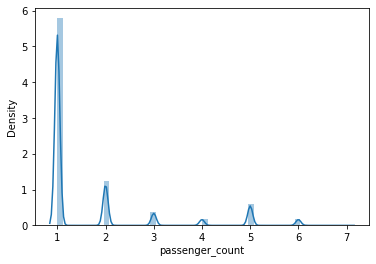

In [24]:
sns.distplot(df['passenger_count'])

## Outlier treatment

<AxesSubplot:xlabel='fare_amount', ylabel='Density'>

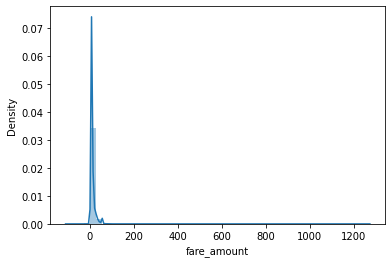

In [25]:
#we can use IQR method quantileremove the outliers from target column
sns.distplot(df['fare_amount'])

In [26]:
q1 = df['fare_amount'].quantile(0.25)
q3 = df['fare_amount'].quantile(0.75)

iqr = q3 - q1
ul = q3 + 1.5*iqr
ll = q1 - 1.5*iqr

In [27]:
df[(df['fare_amount'] > ul) | (df['fare_amount'] < ll)].shape

#there are round 8-9% of outliers, instead of removing it we can take a range of fare price (0.1 to 1000)

(859487, 7)

In [28]:
df = df[df['fare_amount'].between(0.1, 1000)]
df.shape

(9963809, 7)

In [29]:
#we can deal with the data where pickup and drop location is in US
#US latitudes = 30 to 50
#US longitutdes = -65 to -125

In [30]:
df = df[df['pickup_latitude'].between(30, 50)]
df.shape

(9768159, 7)

In [31]:
df = df[df['dropoff_latitude'].between(30, 50)]
df.shape

(9759503, 7)

In [32]:
#we can do the same for longitude

df = df[df['pickup_longitude'].between(-125, -65)]
df.shape

(9758150, 7)

In [33]:
df = df[df['dropoff_longitude'].between(-125, -65)]
df.shape

(9756980, 7)

In [34]:
df_copy = df.copy()

In [35]:
y = df['fare_amount']
X = df.drop('fare_amount', axis=1)

In [36]:
#train test split

from sklearn.model_selection import train_test_split

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=42)

# 1. Base model

### 1.1 Linear regression

In [38]:
from sklearn.linear_model import LinearRegression

from sklearn.metrics import r2_score, mean_squared_error

In [39]:
#we can remove pickup date from X_train and X_test

X_train1 = X_train.drop('pickup_datetime', axis=1)
X_test1 = X_test.drop('pickup_datetime', axis=1)

In [40]:
lir = LinearRegression()
lir.fit(X_train1, y_train)

LinearRegression()

In [41]:
y_test_pred = lir.predict(X_test1)

In [42]:
r2 = r2_score(y_test, y_test_pred)

print('R-sq:', r2)

R-sq: 0.0468644289462109


In [43]:
rmse = mean_squared_error(y_test, y_test_pred) ** 0.5
print('RMSE:', rmse)

RMSE: 9.481548754370607


## XGBRegressor

In [44]:
import xgboost as xgb

In [45]:
%%time

xgr = xgb.XGBRegressor(objective='reg:linear', n_estimators=50, max_depth=5, n_jobs=-1, random_state=42)
xgr.fit(X_train1, y_train)

[05:18:26] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 19min 17s, sys: 1.08 s, total: 19min 18s
Wall time: 5min 13s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=-1, num_parallel_tree=1,
             objective='reg:linear', random_state=42, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='approx',
             validate_parameters=1, verbosity=None)

In [46]:
y_test_pred = xgr.predict(X_test1)

In [47]:
r2 = r2_score(y_test, y_test_pred)
print('R-sq:', r2)

R-sq: 0.7726260028333335


In [48]:
rmse = mean_squared_error(y_test, y_test_pred) ** 0.5
print('RMSE:', rmse)

RMSE: 4.630973992258018


#### We have __R2 = 0.7726__ and __RMSE = 4.63__

# 2. We can create new fetures from Pickup DateTime features
==> Year, Month, Day, Hour, Day_of_week

In [49]:
import datetime as dt

In [50]:
X_train['year'] = X_train['pickup_datetime'].dt.year
X_train['month'] = X_train['pickup_datetime'].dt.month
X_train['day'] = X_train['pickup_datetime'].dt.day
X_train['hour'] = X_train['pickup_datetime'].dt.hour
X_train['day_of_week'] = X_train['pickup_datetime'].dt.weekday


X_test['year'] = X_test['pickup_datetime'].dt.year
X_test['month'] = X_test['pickup_datetime'].dt.month
X_test['day'] = X_test['pickup_datetime'].dt.day
X_test['hour'] = X_test['pickup_datetime'].dt.hour
X_test['day_of_week'] = X_test['pickup_datetime'].dt.weekday

In [51]:
#we can remove pickup date from X_train and X_test

X_train1 = X_train.drop('pickup_datetime', axis=1)
X_test1 = X_test.drop('pickup_datetime', axis=1)


In [52]:
%%time

xgr = xgb.XGBRegressor(objective='reg:linear', n_estimators=50, max_depth=5, n_jobs=-1, random_state=42)
xgr.fit(X_train1, y_train)

[05:23:48] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 26min 12s, sys: 1.8 s, total: 26min 14s
Wall time: 6min 58s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=-1, num_parallel_tree=1,
             objective='reg:linear', random_state=42, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='approx',
             validate_parameters=1, verbosity=None)

In [53]:
y_test_pred = xgr.predict(X_test1)

In [54]:
r2 = r2_score(y_test, y_test_pred)
print('R-sq:', r2)

R-sq: 0.7911241195689583


In [55]:
rmse = mean_squared_error(y_test, y_test_pred) ** 0.5
print('RMSE:', rmse)

RMSE: 4.4386008340188505


#### We have __R2 = 0.7911__ and __RMSE = 4.43__

#### This is an improvement of __2% R-sq__ and __0.2__ drop in RMSE

# 3. Calculating the trip distance - Haversine Distance

The Earth is round but big, so we can consider it flat for short distances. However, flat-Earth formulas for calculating the distance between two points start showing noticeable errors when the distance is more than about 20 kilometers

Therefore, calculating distances on a sphere needs to consider spherical geometry

The haversine formula is a very accurate way of computing distances between two points on the surface of a sphere using the latitude and longitude of the two points



Haversine Formula
The word "Haversine" comes from the function: haversine(θ) = sin²(θ/2)

We can further derive the following:

a = sin²(φB - φA/2) + cos φA * cos φB * sin²(λB - λA/2)

c = 2 * atan2( √a, √(1−a) )

d = R ⋅ c

The following equation where,

φ is latitude
λ is longitude
R is earth’s radius
d is the haversine distance
Note that angles need to be in radians to pass to trig functions

Source: https://community.esri.com/groups/coordinate-reference-systems/blog/2017/10/05/haversine-formula 

In [56]:
from math import radians, cos, sin, asin, sqrt

AVG_EARTH_RADIUS_KM = 6371.0088
AVG_EARTH_RADIUS_MI = 3958.7613

def haversine(start_coord, end_coord, miles=False):
    # get earth radius in required units
    if miles:
        avg_earth_radius = AVG_EARTH_RADIUS_MI
    else:
        avg_earth_radius = AVG_EARTH_RADIUS_KM

    # unpack latitude/longitude
    lat1, lng1 = start_coord
    lat2, lng2 = end_coord

    # convert all latitudes/longitudes from decimal degrees to radians
    lat1, lng1, lat2, lng2 = map(radians, (lat1, lng1, lat2, lng2))

    # calculate haversine
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = sin(lat * 0.5) ** 2 + cos(lat1) * cos(lat2) * sin(lng * 0.5) ** 2
    
    return 2 * avg_earth_radius * asin(sqrt(d))

In [57]:
X_train.drop(columns=['pickup_datetime'], inplace=True)
X_test.drop(columns=['pickup_datetime'], inplace=True)

In [58]:
X_train['haversine_dist'] = X_train.apply(lambda row: haversine(start_coord=(row['pickup_latitude'], 
                                                                             row['pickup_longitude']),
                                                                end_coord=(row['dropoff_latitude'], 
                                                                           row['dropoff_longitude'])), axis=1)

X_test['haversine_dist'] = X_test.apply(lambda row: haversine(start_coord=(row['pickup_latitude'], 
                                                                             row['pickup_longitude']),
                                                                end_coord=(row['dropoff_latitude'], 
                                                                           row['dropoff_longitude'])), axis=1)
X_train.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,year,month,day,hour,day_of_week,haversine_dist
1318766,-73.972536,40.763026,-73.961234,40.777599,1,2013,4,13,14,5,1.879280
9943785,-73.981595,40.767030,-73.981777,40.746655,1,2014,2,27,14,3,2.265652
1489642,-73.985237,40.738292,-73.969937,40.757192,1,2011,11,22,14,1,2.465334
4167784,-73.976457,40.751596,-73.975751,40.776474,1,2013,4,3,3,2,2.766950
5771148,-73.961794,40.764302,-73.966349,40.758159,1,2012,11,21,9,2,0.783431


In [59]:
%%time

xgr = xgb.XGBRegressor(objective='reg:linear', n_estimators=50, max_depth=5, n_jobs=-1, random_state=42)
xgr.fit(X_train, y_train)

[05:35:54] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 29min 52s, sys: 2.4 s, total: 29min 55s
Wall time: 8min 50s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=-1, num_parallel_tree=1,
             objective='reg:linear', random_state=42, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='approx',
             validate_parameters=1, verbosity=None)

In [60]:
y_test_pred = xgr.predict(X_test)

r2 = r2_score(y_test, y_test_pred)
print('R-sq:', r2)

rmse = mean_squared_error(y_test, y_test_pred) ** 0.5
print('RMSE:', rmse)

R-sq: 0.8209055100817099
RMSE: 4.110011678138375


#### We have __R2 = 0.8209__ and __RMSE = 4.11__

#### This is an improvement of __3% R-sq__ and __0.32__ drop in RMSE

# 4. PolynomialFeatures

In [61]:
from sklearn.preprocessing import  PolynomialFeatures

In [62]:
poly = PolynomialFeatures(degree=1)

In [63]:
polyXtrain = poly.fit_transform(X_train)
polyXtest = poly.transform(X_test)

In [64]:
%%time

xgr = xgb.XGBRegressor(objective='reg:linear', n_estimators=50, max_depth=5, n_jobs=-1, random_state=42)
xgr.fit(polyXtrain, y_train)

[05:51:12] WARNING: ../src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
CPU times: user 29min 29s, sys: 4.01 s, total: 29min 33s
Wall time: 8min 35s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=50, n_jobs=-1, num_parallel_tree=1,
             objective='reg:linear', random_state=42, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='approx',
             validate_parameters=1, verbosity=None)

In [65]:
y_test_pred = xgr.predict(polyXtest)

r2 = r2_score(y_test, y_test_pred)
print('R-sq:', r2)

rmse = mean_squared_error(y_test, y_test_pred) ** 0.5
print('RMSE:', rmse)

R-sq: 0.8209055100817099
RMSE: 4.110011678138375


#### We have __R2 = 0.8209__ and __RMSE = 4.11__
#### There is no difference, we can consider this as our final model